In [1]:
import warnings
warnings.filterwarnings('ignore')

# Activity Comparison
In this notebook we look at activity levels from participants from the UT1000, UT2000, and UTx000 studies. 

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

from scipy import stats
from scipy.stats import linregress

# Table of Contents
1. [Data Import](#data_import)
    1. [Target Data: Fitbit Sleep](#targets)
    2. [Feature Data: Fitbit Activity](#features)
2. [Pre-Processing](#preprocessing)
    1. [Target Data](#target_data)
        1. Summary
        1. Scaling
    2. [Feature Data](#feature_data)
3. [Analyzing Relationships](#analysis)

In [3]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2

<a id='data_import'></a>

# Constant Participation
We might check to see if there are any participants that have been in all three studes.

## Importing EIDs
The only ID that would link participants across studies _for certain_ would be their EIDs. The REDCap database has all this information.

In [4]:
eids_1 = pd.read_csv("../data/raw/ut1000/admin/participant_eids.csv")
eids_2 = pd.read_csv("../data/raw/ut2000/admin/participant_eids.csv")
eids_x = pd.read_csv("../data/raw/utx000/admin/participant_eids.csv")

## Comparing Participants Across Studies
Now we can compare the EIDs across studies and see what overlap we have. 

In [5]:
from functools import reduce

dfs = [eids_1,eids_x]
one_and_x = reduce(lambda left,right: pd.merge(left,right,on='uteid'), dfs)
print("Number of Participants from both studies:",len(one_and_x))

Number of Participants from both studies: 4


<div class="alert alert-block alert-success">
    
We have **four** participants from both the UT1000 and UTx000 study.
    
</div>

In [6]:
dfs = [eids_1,eids_2]
one_and_two = reduce(lambda left,right: pd.merge(left,right,on='uteid'), dfs)
print("Number of Participants from both studies:",len(one_and_two))

Number of Participants from both studies: 28


<div class="alert alert-block alert-success">
    
We have **28** people from both the UT1000 and UT2000 studies
    
</div>

In [7]:
dfs = [eids_2,eids_x]
two_and_x = reduce(lambda left,right: pd.merge(left,right,on='uteid'), dfs)
print("Number of Participants from both studies:",len(two_and_x))

Number of Participants from both studies: 0


<div class="alert alert-block alert-danger">
    
We have **NO** overlap between the UT2000 and UTx000 studies which also means we have no participant who participated in all three studies. 
    
</div>

<a id='aggregate'></a>

# Pre-Processing
We need to do a little pre-processing in order to massage the data into a form that can be used.

## Data Importing and Cleaning

### UT1000
Data are summarized in the `dailyActivity` file.

In [8]:
u1_raw = pd.read_csv("../data/raw/ut1000/fitbit/dailyActivity_merged.csv",parse_dates=["ActivityDate"],infer_datetime_format=True)
u1_raw.drop(["TrackerDistance","VeryActiveDistance","ModeratelyActiveDistance","LightActiveDistance","SedentaryActiveDistance","LoggedActivitiesDistance","Floors","MarginalCalories","RestingHeartRate","CaloriesBMR"],axis="columns",inplace=True)
u1_raw.columns = ["pid","timestamp","steps","distance","very_active_minutes","fairly_active_minutes","lightly_active_minutes","sedentary_minutes","calories"]
print(f"{len(u1_raw)} observations from {len(u1_raw['pid'].unique())} participants")

184 observations from 32 participants


### UT2000
Now daily activity file exists for this study nor is the Fitabase account active to retrieve it from. Therefore, we have to import the individual files and concatenate them.

In [9]:
# steps
u2_steps = pd.read_csv("../data/raw/ut2000/fitbit/dailySteps_merged.csv",parse_dates=["ActivityDay"],infer_datetime_format=True)
# intensities
u2_int = pd.read_csv("../data/raw/ut2000/fitbit/dailyIntensities_merged.csv",parse_dates=["ActivityDay"],infer_datetime_format=True)
u2_int["distance"] = u2_int[[column for column in u2_int.columns if column.endswith("Distance")]].sum(axis="columns")
# calories
u2_cal = pd.read_csv("../data/raw/ut2000/fitbit/dailyCalories_merged.csv",parse_dates=["ActivityDay"],infer_datetime_format=True)
# combining and cleaning
u2_raw = reduce(lambda left,right: pd.merge(left,right,on=["Id","ActivityDay"]), [u2_steps,u2_int,u2_cal])
u2_raw.drop([column for column in u2_raw.columns if column.endswith("Distance")],axis="columns",inplace=True)
u2_raw.columns = ["pid","timestamp","steps","sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes","distance","calories"]
print(f"{len(u2_raw)} observations from {len(u2_raw['pid'].unique())} participants")

167 observations from 9 participants


### UTX000

In [10]:
ux_raw = pd.read_csv("../data/processed/fitbit-daily-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
ux_raw.drop(["calories_from_activities","bmi","bmr","fat","weight","food_calories_logged","water_logged"],axis="columns",inplace=True)
ux_raw.rename(columns={'beiwe':'pid'}, inplace=True)
print(f"{len(ux_raw)} observations from {len(ux_raw['pid'].unique())} participants")

5309 observations from 59 participants


## Including Additional Columns
There are a few extra pieces of information that we might want to include, like:
* **Day of Week** (`dow`): Can help us group the data by day and by weekday/weekend

In [12]:
act = {"ut1000":u1_raw,"ut2000":u2_raw,"utx000":ux_raw}

for df in act.values():
    df["timestamp"] = pd.to_datetime(df["timestamp"]) # making sure timestamp is datetime
    df["dow"] = df["timestamp"].dt.strftime("%a") # getting day of week column

# Analyzing Across Aggregated Datasets
We start by looking at general relationships between the studies instead of individuals.

## Summary DataFrame
This DataFrame includes summary measurements from each study for each of the _important_ activity metrics.

In [14]:
metrics = [column for column in u1_raw.columns if column not in ["timestamp","dow","bmr","calories","pid","study"]]
summary = {metric: [] for metric in metrics}
summary["study"] = []
summary["aggregate"] = []

for study, data in act.items():
    for agg, f in zip(["mean","median"],[np.mean,np.median]):
        summary["study"].append(study)
        summary["aggregate"].append(agg)
        for metric in metrics:
            summary[metric].append(f(data[metric]))
        
summary_act = pd.DataFrame(summary)

## Combined DataFrame
For later analysis, we might be interested in using a DataFrame that contains all the observations from each of the three studies.

In [15]:
def get_study_number(study):
    """gets a numerical encoding for the study"""
    if study == "ut1000":
        return 1
    elif study == "ut2000":
        return 2
    else:
        return 0

In [16]:
for study, df in zip(act.keys(),[u1_raw,u2_raw,ux_raw]):
    df["study"] = study
combined_act = pd.concat([u1_raw,u2_raw,ux_raw])
combined_act.reset_index(inplace=True,drop=True)
for metric in metrics:
    combined_act[metric] = pd.to_numeric(combined_act[metric])
    
combined_act["study_no"] = combined_act.apply(lambda x: get_study_number(x["study"]),axis="columns")
combined_act["pid"] = combined_act.groupby("pid").ngroup()

## Visualizing
We can look at the study measurements using a few different vizualizations.

### Distribution - KDE Plots
Starting with KDE plots to get general insight into how the distribution of measurements might vary between studies.

In [17]:
def plot_distribution(df, var):
    """KDE plots"""
    n_studies = len(df["study"].unique())
    fig, ax = plt.subplots(figsize=(16,4))
    for study in df["study"].unique():
        df_by_study = df[df["study"] == study]
        sns.kdeplot(df_by_study[var],cut=0,linewidth=2,label=study,ax=ax)

    # x-axis
    plt.xticks(fontsize=14)
    # y-axis
    ax.set_ylabel(var.replace("_"," ").title(),fontsize=16)
    ax.set_yticks([])
    # remainder
    for loc in ["left","top","right"]:
        ax.spines[loc].set_visible(False)

    ax.legend(title="Study",frameon=False,ncol=3,title_fontsize=14,fontsize=12)
            
    plt.show()
    plt.close()

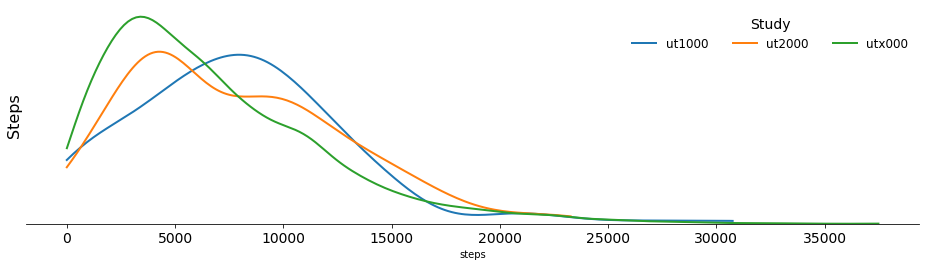

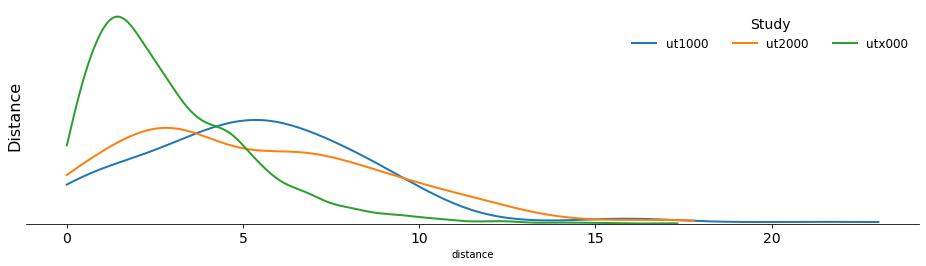

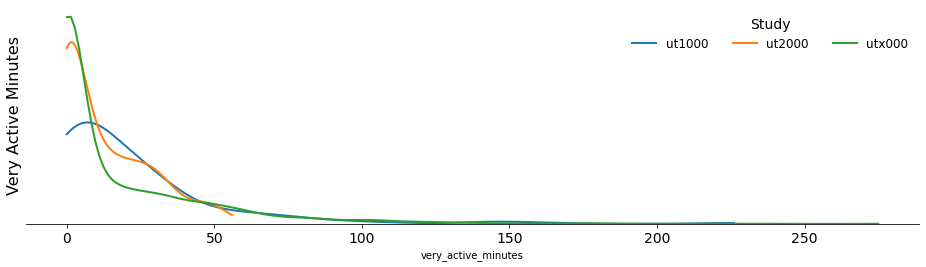

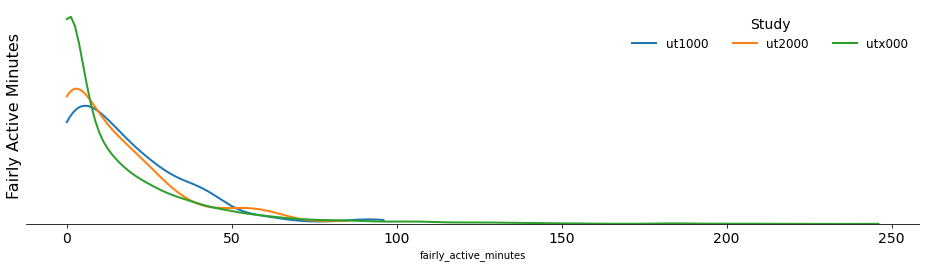

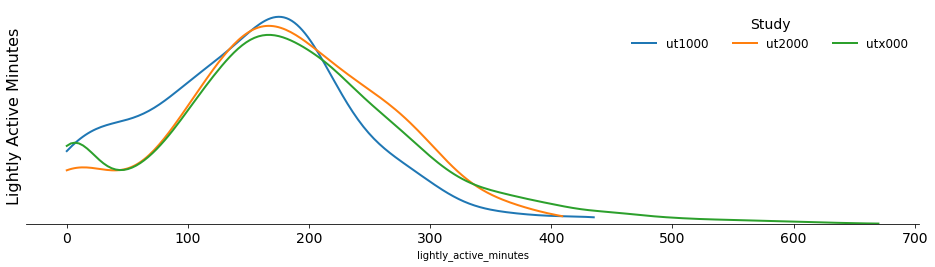

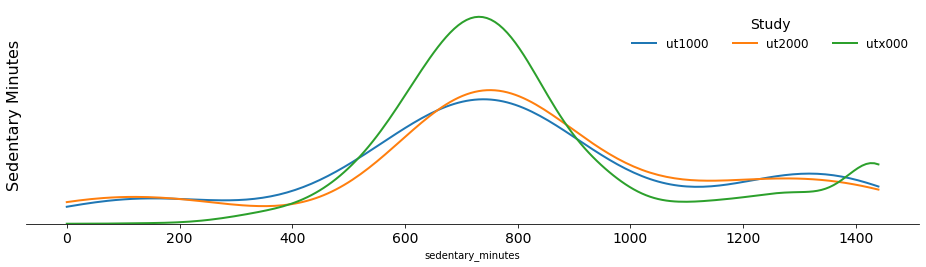

In [18]:
for metric in metrics:
    plot_distribution(combined_act, metric)

<div class="alert alert-block alert-success">
    
At least on an aggregate level, the participants in the UTx000 study tended to be less active, logging lower mean and median `steps`, `distance`, `very_active_minutes`, and `fairly_active_minutes` measurements.
    
</div>

### Bar Plots

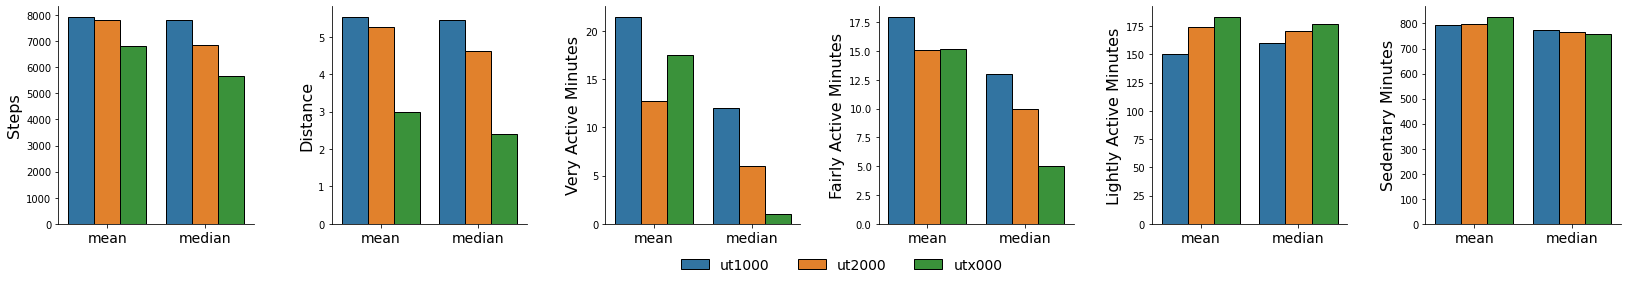

In [20]:
fig, axes = plt.subplots(1,6,figsize=(28,4))
for metric, ax in zip(metrics, axes.flat):
    sns.barplot(x="aggregate",y=metric,hue="study",edgecolor="black",data=summary_act,ax=ax)
    # x-axis
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
    # y-axis
    ax.set_ylabel(metric.replace("_"," ").title(),fontsize=16)
    # remainder
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    if metric == "fairly_active_minutes":
        ax.legend(frameon=False,title=None,bbox_to_anchor=(0.7,-0.1),ncol=3,fontsize=14)
    else:
        ax.get_legend().remove()
    
plt.subplots_adjust(wspace=0.4)
plt.show()
plt.close()

<div class="alert alert-block alert-success">
    
At least on an aggregate level, the participants in the UTx000 study tended to be less active, logging lower mean and median `steps`, `distance`, `very_active_minutes`, and `fairly_active_minutes` measurements.
    
</div>

### Violins

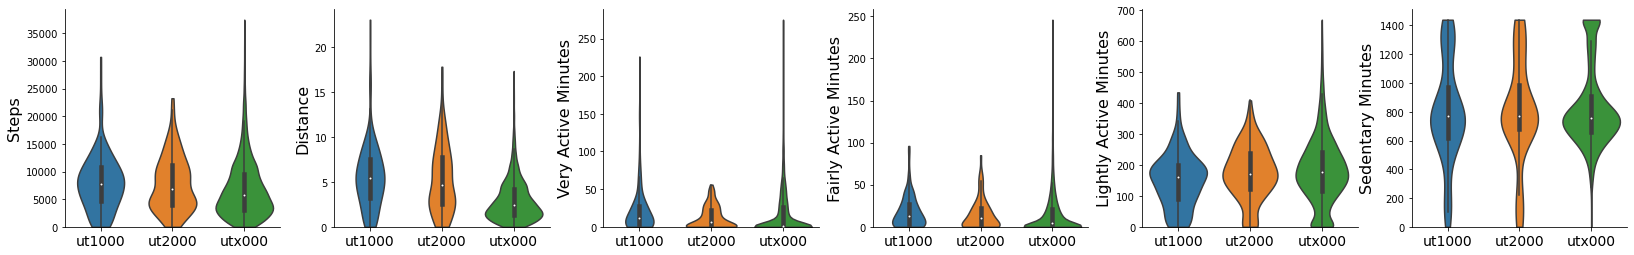

In [21]:
fig, axes = plt.subplots(1,6,figsize=(28,4))
for metric, ax in zip(metrics, axes.flat):
    sns.violinplot(x="study",y=metric,data=combined_act,cut=0,ax=ax)
    # x-axis
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
    # y-axis
    ax.set_ylabel(metric.replace("_"," ").title(),fontsize=16)
    ax.set_ylim(bottom=0)
    # remainder
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
        
plt.subplots_adjust(wspace=0.25)
plt.show()
plt.close()

## Pre- versus During COVID
We only have _potentially_ four participants that provided data from both the UT1000 and the UTx000 studies whereas we have no overlap between UT2000 and UTx000. Therefore, we need to look at an **unpaired** test for difference between the two groups. Additionally, I would not be confident saying that any of our distributions are Gaussian, therefore the test must also allow us to compare non-Gaussain distributions.

The test of choice is the **[Mann-Whitney U Test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)**. There are five assumptions (four from the test itself and one from the Python function) that must be satisfied:
1. **Ordinal or Continuous Variable**: All the activity metrics are continuous
2. **Two, Categorical Independent Groups**: We have two groups (pre-COVID i.e. UT1000 + UT2000 and during COVID i.e. UTx000) and as long as we remove any overlapping participants, we satisfy this assumption.
3. **Independence of Observations**: There should not be any relationships between the participants within a group, but I suppose this means that we have to take average values from each of our participants since some participants will contribute more.
4. **Similiar Distributions**: This test allows us to examine differences between distributions that are not Gaussian, but are _similar_. Based on the KDE plots above, this assumption should hold.
5. **>20 Observations**: The function from SciPy requires that 20 observations be in each group. This assumption forces us to combine the UT1000 and UT2000 datasets since we only have 9 participants from the UT2000 dataset.

In [44]:
from scipy.stats import mannwhitneyu, ranksums

### Setting Up DataFrame
We take the `combined_act` DataFrame and collapse it into a `pre_and_during_act` DataFrame that has mean values for each unique participant from the pre-COVID studies (UT1000 and UT2000) and during COVID (UTx000).

In [29]:
temp = combined_act.copy()
temp["covid"] = ["during" if study == "utx000" else "pre" for study in temp["study"]]
pre_and_during_act = temp.groupby(["pid","covid"]).mean().reset_index()
pre_and_during_act["covid"].value_counts()

during    59
pre       41
Name: covid, dtype: int64

<div class="alert alert-block alert-success">

Grouping this way, we actually get nearly equal representation of pre- and during COVID responses which should give us some good statistical power.
    
</div>

### Visualizing
We can look at the distributions again to get a sense if we can visually see a difference.

In [90]:
def plot_comparision_violin(df_in,target,test="COVID Timeline",hue="covid",annotate=True):
    """plots violine comparing distributions from different groups"""
    df = df_in.copy()
    df["test"] = test
    fig, ax = plt.subplots(figsize=(4,4))
    sns.violinplot(x="test",y=target,hue=hue,data=df,
                   palette=["seagreen","white"],split=True,inner="quartile",cut=0,ax=ax)
    # x-axis
    ax.set_xticks([])
    ax.set_xlabel("")
    # y-axis
    ax.set_ylabel(target.replace("_"," ").title(),fontsize=14)
    plt.yticks(fontsize=11)
    # remainder
    for loc in ["top","right","bottom"]:
        ax.spines[loc].set_visible(False)
    ax.legend(title=test,title_fontsize=12,fontsize=10,frameon=False,loc="upper center", bbox_to_anchor=(0.5,0),ncol=2)
    
    if annotate and len(list(df[hue].unique())) == 2:
        gs = list(df[hue].unique())
        g1 = df[df[hue] == gs[0]].loc[:,target]
        g2 = df[df[hue] == gs[1]].loc[:,target]
        _, p = mannwhitneyu(g1,g2)
        w = "bold" if p < 0.05 else "normal"
        ax.set_title(f"p: {round(p,4)}",fontsize=12,pad=0,fontweight=w)
    
    plt.show()
    plt.close()

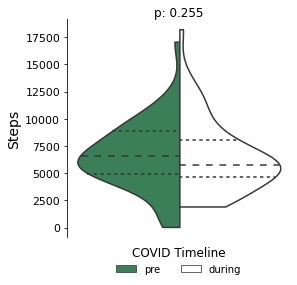

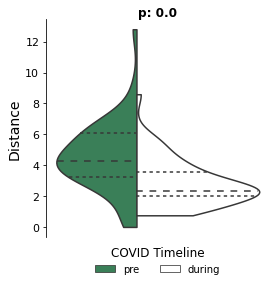

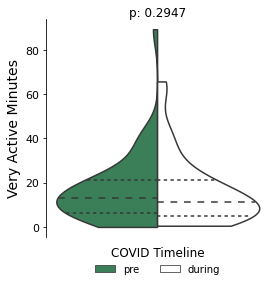

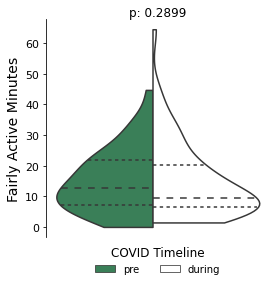

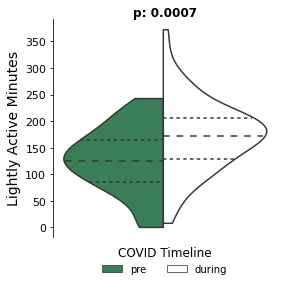

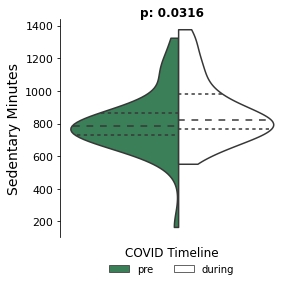

In [91]:
for metric in metrics:
    plot_comparision_violin(pre_and_during_act,target=metric)

### Conducting Test
Now we see if the distributions differ. While the test of choice is the Mann-Whitney U Test, these test alters the p-values to account for a continuous distribution predicting the outcome of a categorical/binary variable. A similar test, that does not take this _continuity correction_ into account is the Wilcoxon Ranked Sums test. We try both out below to see the differences.

#### Mann-Whitney U

In [112]:
print(f"Metric{'':<17s} Mann-Whitney |   Wilcoxon")
for metric in metrics:
    pre = pre_and_during_act[pre_and_during_act["covid"] == "pre"].loc[:,metric]
    during = pre_and_during_act[pre_and_during_act["covid"] == "during"].loc[:,metric]
    _, p_mwu = mannwhitneyu(pre,during)
    _, p_wrs = ranksums(pre,during)
    print(f"{metric.replace('_',' ').title():<25s} {round(p_mwu,4):<10f} |   {round(p_wrs,4):<10f}")

Metric                  Mann-Whitney |   Wilcoxon
Steps                     0.255000   |   0.507800  
Distance                  0.000000   |   0.000000  
Very Active Minutes       0.294700   |   0.587000  
Fairly Active Minutes     0.289900   |   0.577400  
Lightly Active Minutes    0.000700   |   0.001300  
Sedentary Minutes         0.031600   |   0.062800  


#### Wilcoxon Ranked Sum

In [47]:
for metric in metrics:
    pre = pre_and_during_act[pre_and_during_act["covid"] == "pre"].loc[:,metric]
    during = pre_and_during_act[pre_and_during_act["covid"] == "during"].loc[:,metric]
    print(f"{metric}: {round(p,4)}")

steps: 0.5078
distance: 0.0
very_active_minutes: 0.587
fairly_active_minutes: 0.5774
lightly_active_minutes: 0.0013
sedentary_minutes: 0.0628


<div class="alert alert-block alert-info">

The difference between the two tests is simply that the Mann-Whitney U test takes the p-values from the Wilcoxon test and multiplies them by a constant, the default being 0.5.
    
</div>

# By DoW
Now we can look based on the day of the week.

In [24]:
act_by_dow = combined_act.groupby(["dow","study"]).mean().reset_index()

## Visualizing
Getting an initial impression of the data.

### Violin Plots

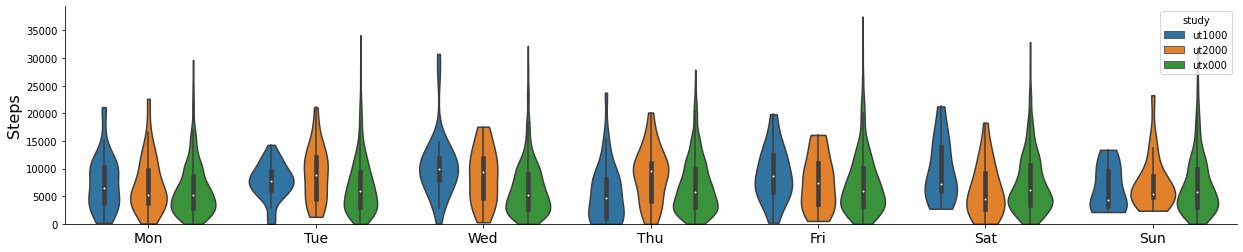

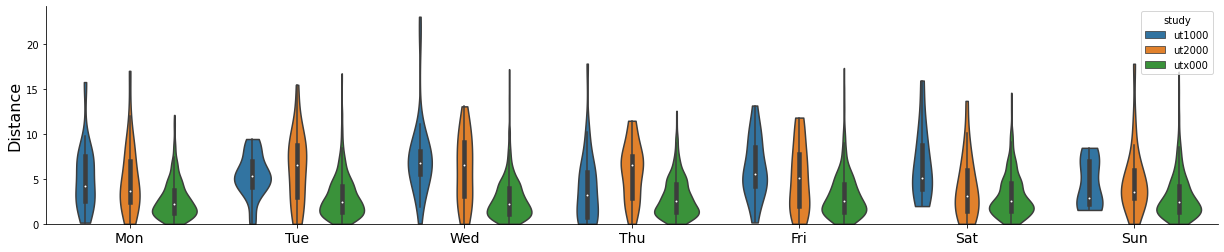

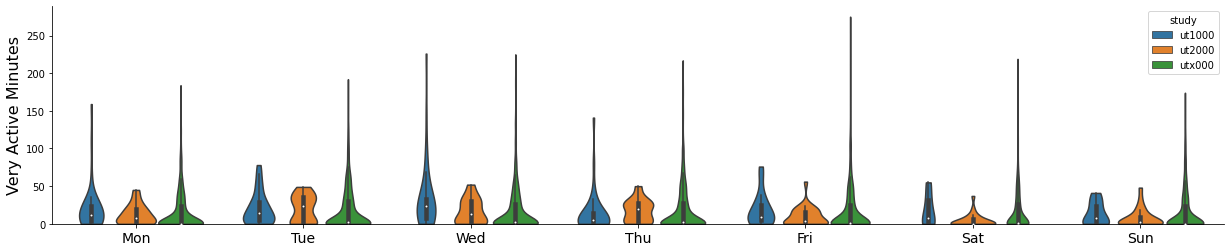

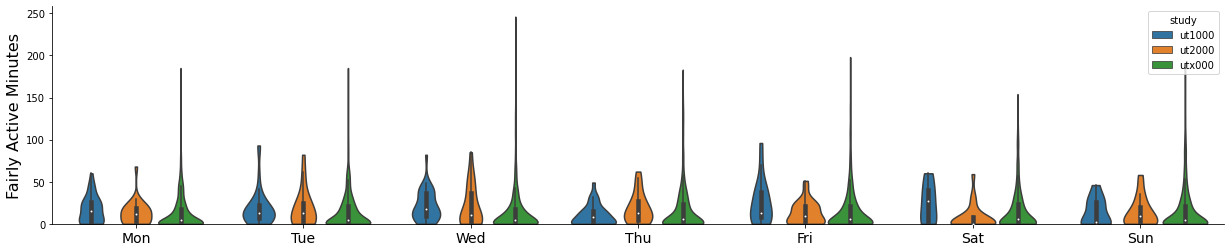

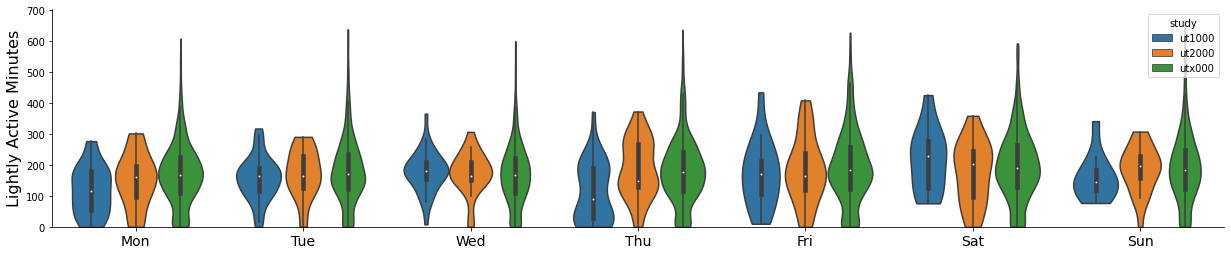

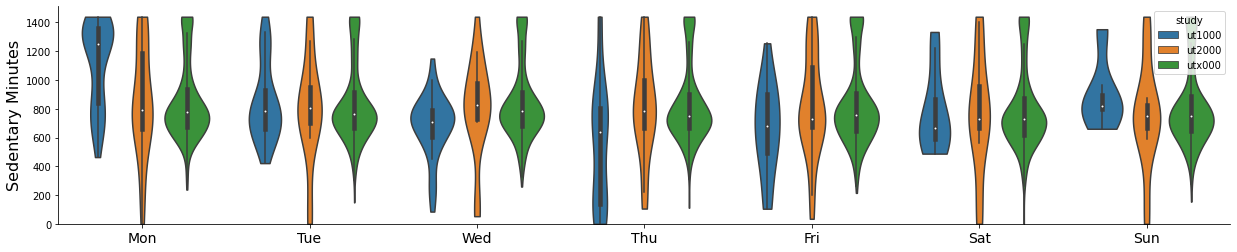

In [113]:
for metric in metrics:
    fig, ax = plt.subplots(figsize=(21,4))
    sns.violinplot(x="dow",y=metric,hue="study",data=combined_act,cut=0,ax=ax)
    # x-axis
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
    # y-axis
    ax.set_ylabel(metric.replace("_"," ").title(),fontsize=16)
    ax.set_ylim(bottom=0)
    # remainder
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)

## Pre- versus During COVID
Similar analysis to before, but now we group participant's data collection by day of the week before consolidating into one measurement. 

In [131]:
### Number of Observations
We start by checking the number of observations for each day of the week from each study and look at the number of participants that contributed to those observations. 

temp = combined_act.copy()
temp["covid"] = ["during" if study == "utx000" else "pre" for study in temp["study"]]
pre_and_during_dow = temp.groupby(["pid","covid","dow"]).mean().reset_index()
for dow in pre_and_during_dow["dow"].unique():
    by_day = pre_and_during_dow[pre_and_during_dow["dow"] == dow]
    pre = by_day[by_day["covid"] == "pre"]
    during = by_day[by_day["covid"] == "during"]
    print(dow.upper())
    print(f"\tPre:\t{len(pre)}")
    print(f"\tDuring:\t{len(during)}")

FRI
	Pre:	16
	During:	58
MON
	Pre:	37
	During:	59
SAT
	Pre:	16
	During:	58
SUN
	Pre:	16
	During:	59
THU
	Pre:	34
	During:	59
TUE
	Pre:	38
	During:	58
WED
	Pre:	36
	During:	58


In [167]:
def plot_comparision_violins(df_in,target,annotate=True):
    """plots violine comparing distributions from different groups"""
    df = df_in.copy()
    fig, ax = plt.subplots(figsize=(16,6))
    sns.violinplot(x="dow",y=target,hue="covid",data=df,
                   palette=["seagreen","white"],split=True,inner="quartile",cut=0,ax=ax)
    # x-axis
    ax.set_xlabel("Day of Week",fontsize=14)
    plt.xticks(fontsize=12)
    # y-axis
    ax.set_ylabel(target.replace("_"," ").title(),fontsize=14)
    plt.yticks(fontsize=11)
    # remainder
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    ax.legend(title="COVID Timeline",title_fontsize=12,fontsize=10,frameon=False,loc="upper center", bbox_to_anchor=(1.05,1),ncol=1)
    

    if annotate:
        for i, d in enumerate(df["dow"].unique()):
            df_by_day = df[df["dow"] == d]
            g1 = df_by_day[df_by_day["covid"] == "pre"].loc[:,target]
            g2 = df_by_day[df_by_day["covid"] == "during"].loc[:,target]
            _, p = mannwhitneyu(g1,g2)
            w = "bold" if p < 0.05 else "normal"
            ax.text(i,max(df_by_day[target])*1.1,f"p: {round(p,3)}",fontsize=12,ha="center",fontweight=w)
    
    plt.show()
    plt.close()

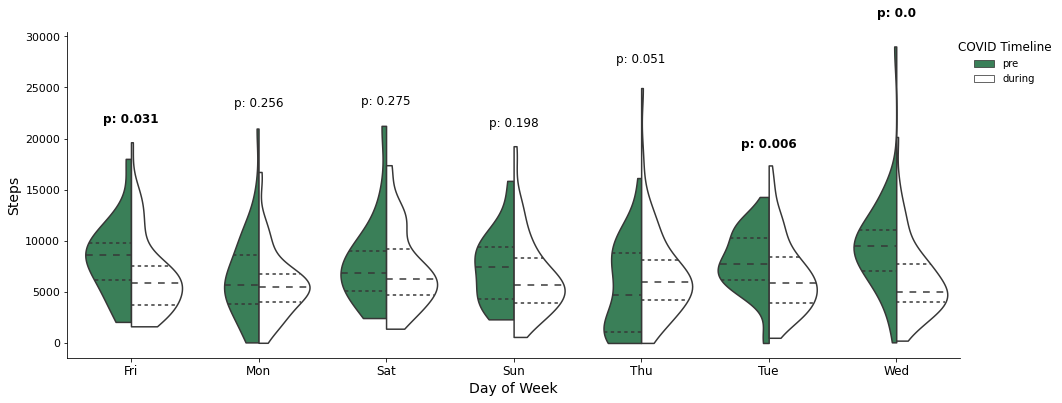

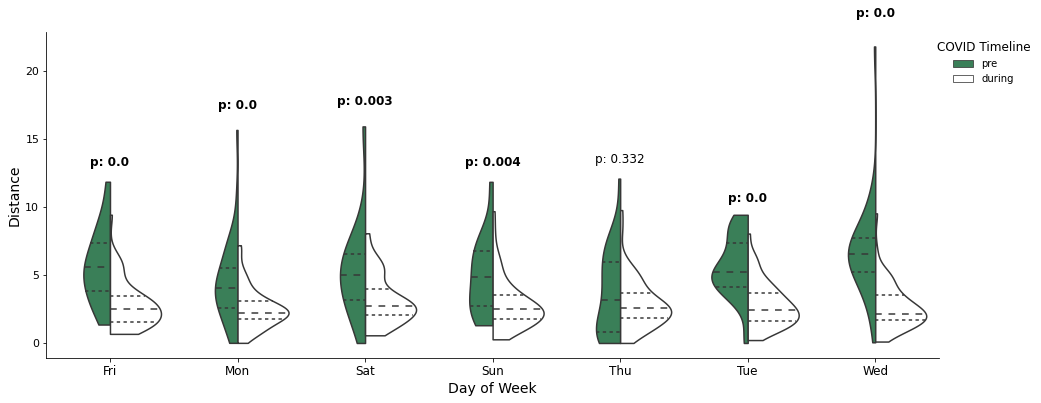

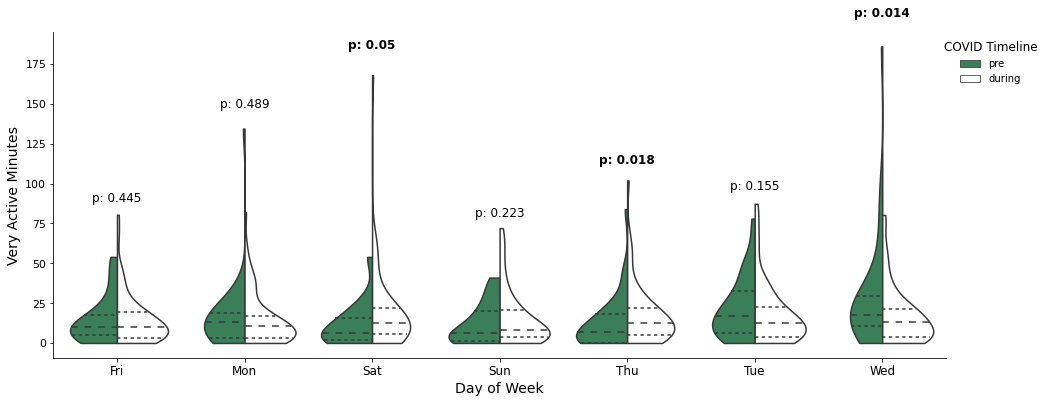

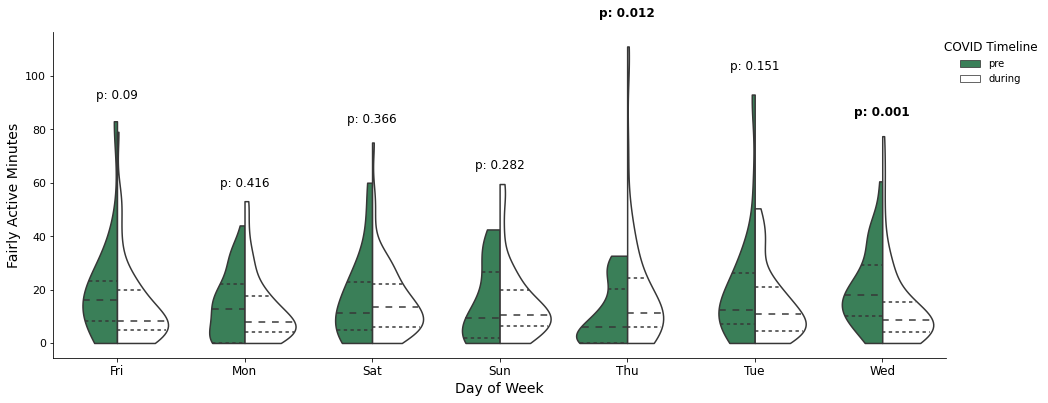

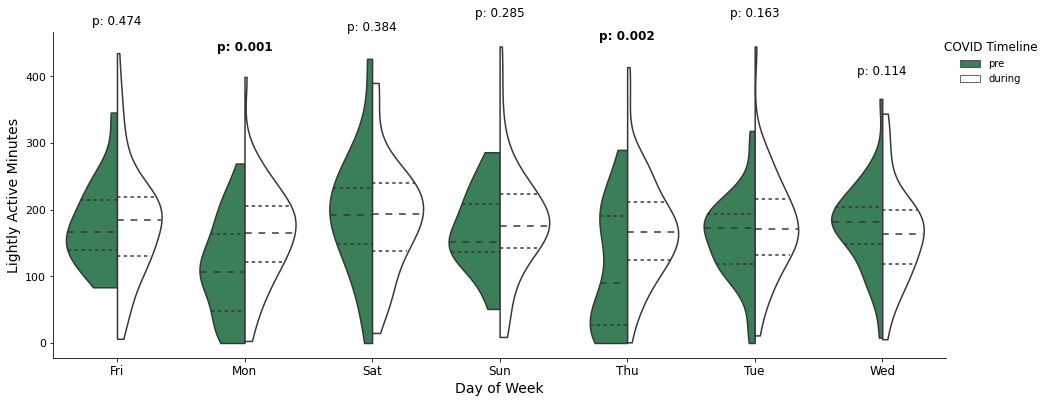

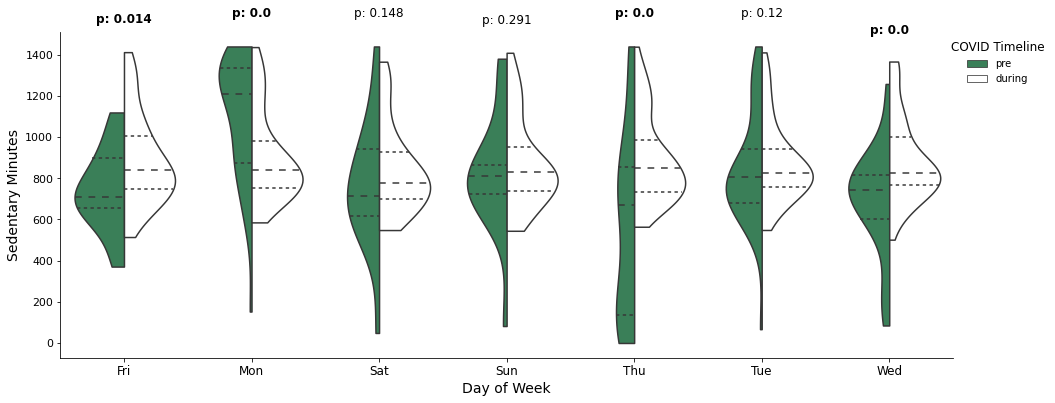

In [169]:
for metric in metrics:
    plot_comparision_violins(pre_and_during_dow, metric)

# Comparing UT1000 to UTx000
We now look at the four participants who were in both the UT1000 and UTx000 studies.

## Gathering Pertinent Data
Although we have four participants registered in both studies, we have to first make sure that all participant received/used a Fitbit.

### Combining IDs from each study
Have to link based on EIDs.

In [170]:
u1_id_key = pd.read_csv("../data/raw/ut1000/admin/id_crossover.csv",usecols=range(0,5))
ux_id_key = pd.read_excel("../data/raw/utx000/admin/id_crossover.xlsx")
u1x_id_key = pd.merge(left=u1_id_key,right=ux_id_key,on=["eid"],suffixes=["_u1","_ux"])

### Data from UT1000 Participants
We use the `pid` column from the UT1000 study and cross-reference that with the `record` ID from the ID key file.

In [178]:
u1_long_data = u1_raw[u1_raw["pid"].isin(u1x_id_key["record"])]
u1_long_data = u1_long_data.merge(u1x_id_key[["record","eid"]],left_on=["pid"],right_on=["record"],how="inner").drop(["record","pid"],axis="columns")
print("Number of active participants:", len(u1_long_data["eid"].unique()))

Number of active participants: 1


### Data from UTx000 Participants
We use the `beiwe` column from the UTx000 study with the `beiwe_ux` column from the ID key file. 

In [180]:
ux_long_data = ux_raw[ux_raw["pid"].isin(u1x_id_key["beiwe_ux"])]
ux_long_data = ux_long_data.merge(u1x_id_key[["beiwe_ux","eid"]],left_on=["pid"],right_on=["beiwe_ux"],how="inner").drop(["pid","beiwe_ux"],axis="columns")
print("Number of active participants:", len(ux_long_data["eid"].unique()))

Number of active participants: 3


### Combined Dataset
Now we see the overlap.

In [184]:
u1x_participants = [pt for pt in u1_long_data["eid"].unique() if pt in ux_long_data["eid"].unique()]
print("Number of participants:", len(u1x_participants))

Number of participants: 1


<div class="alert alert-block alert-danger">
    
Unfortunately, out of the four possible participants, we only have **one** participant that actively collected activity data in both studies. 
    
</div>

In [185]:
u1_overlap = u1_long_data[u1_long_data["eid"].isin(u1x_participants)].drop(["eid"],axis="columns")
ux_overlap = ux_long_data[ux_long_data['eid'].isin(u1x_participants)].drop(["eid"],axis="columns")
u1x_data = {"ut1000":u1_overlap,"utx000":ux_overlap}
print("Number of Observations:")
for study, data in u1x_data.items():
    print(f"\t{study}: {len(data)}")

Number of Observations:
	ut1000: 12
	utx000: 129
